# Force prediction error

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.extended_kalman_vmm import ExtendedKalman, SystemMatrixes
from vmm_abkowitz_diminished import vmm as vmm
from wPCC_pipeline.pipelines.brix.nodes import initial_parameters, extract_added_masses
from wPCC_pipeline.pipelines.preprocess.nodes import load, add_thrust
from wPCC_pipeline.pipelines.filter_data_extended_kalman.nodes import guess_covariance_matrixes, initial_state, extended_kalman_filter, extended_kalman_smoother
from wPCC_pipeline.pipelines.motion_regression.nodes import predict_force, fit_motions, create_model_from_motion_regression
from wPCC_pipeline.pipelines.prediction.nodes import simulate_euler
from phd.pipelines.load_7m.nodes import fix_interpolated_angle
from sklearn.metrics import mean_squared_error
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator, get_coefficients
import sympy as sp
from functools import reduce
from operator import add
from vessel_manoeuvring_models.symbols import *
import vessel_manoeuvring_models.symbols as symbols
from IPython.display import display
from vessel_manoeuvring_models.prime_system import df_prime
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify, get_function_subs
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator
from vessel_manoeuvring_models.parameters import df_parameters
from phd.helpers import mean
from vessel_manoeuvring_models.angles import mean_angle
from vessel_manoeuvring_models.angles import smallest_signed_angle
from phd.visualization.maps import plot_map, plot_trips, plot_missions, plot_tests
import inspect
from sklearn.metrics import r2_score
from scipy.optimize import least_squares
import statsmodels.api as sm

import logging
log = logging.getLogger(__name__)

import matplotlib.pyplot as plt
plt.style.use('bmh')

In [3]:
import anyconfig
globals_path = "../conf/base/globals.yml"
global_variables = anyconfig.load(globals_path)
ships = global_variables["ships"]

In [4]:
%reload_kedro
ship='7m'

time_series = catalog.load(f"{ship}.tests")
ship_data = catalog.load(f"{ship}.ship_data")
exclude_parameters = catalog.load(f"params:{ship}.exclude_parameters")
time_series_meta_data = catalog.load(f"{ ship }.test_meta_data")
time_series_meta_data['date'] = pd.to_datetime(time_series_meta_data['date'])
time_series_meta_data.sort_values(by='date', inplace=True)
time_series_meta_data.index = time_series_meta_data.index.astype(str)
model_loaders = catalog.load(f"{ship}.models")
units = catalog.load(f"{ship}.units")

[07/06/23 13:42:46] INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=409594;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=718134;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[07/06/23 13:42:53] INFO     Kedro project phd                                                      ]8;id=510514;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=832421;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=514182;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=913847;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

                    INFO     Registered line magic 'run_viz'                                        ]8;id=822344;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=200662;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#110\110]8;;\

                    INFO     Loading data from '7m.tests' (PartitionedDataSet)...               ]8;id=750438;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=874565;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.ship_data' (YAMLDataSet)...                  ]8;id=537651;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=829374;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'params:7m.exclude_parameters'                   ]8;id=691817;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=796506;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (MemoryDataSet)...                                                                    

                    INFO     Loading data from '7m.test_meta_data' (CSVDataSet)...              ]8;id=104837;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=751460;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.models' (PartitionedDataSet)...              ]8;id=213654;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=507816;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.units' (YAMLDataSet)...                      ]8;id=77236;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=282050;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [5]:
model_no_wind = model_loaders['vmm_abkowitz_diminished']()
#model_wind = model_loaders["MDL_modular_propeller_rudder_wind"]()
model_wind = model_loaders["VCT_MDL_resistance_wind"]()



In [6]:
symbols_dict = {key:symbol for key,symbol in symbols.__dict__.items() if isinstance(symbol, sp.Symbol)}

In [7]:
_ = []
for id, loader in time_series.items():
    df_ = loader()
    df_['id'] = str(id)
    _.append(df_)
    
data_all = pd.concat(_)
data_all.set_index("global time", inplace=True)
assert data_all.index.is_unique
data_all.sort_index(inplace=True)
data_all['trip_no'] = data_all['id'].astype(int)

In [8]:
plot_tests(data_all, meta_data = time_series_meta_data, width=1400, height=800, zoom_start=15)

In [9]:
data = data_all.drop(columns=['mission','date'])
mask = data['thrusterTarget'].between(1,100)
data = data.loc[mask].copy()

groups = data.groupby(by='thrusterTarget')
data = groups.filter(lambda x : len(x) > 100)

rev_guess=8.1
data['rev'] = rev_guess
states = data[['x0','y0','psi','u','v','r']]
control=data[model_wind.control_keys]


In [10]:
data['thrusterTarget'].unique()

array([ 20.,  40.,  60.,  80., 100.,  50.])

In [11]:
def calculate_fx(data, rev):
    
    control = data[model_wind.control_keys]
    states = data[['x0','y0','psi','u','v','r']]
    control['rev'] = rev
    df_force_predicted = pd.DataFrame(model_wind.calculate_forces(states_dict=states, control=control))
    df_force_predicted['fx'] = run(model_wind.lambda_X_D, inputs=df_force_predicted)
    return df_force_predicted
    

def predict_fx_rev(x, data:pd.DataFrame, df_force:pd.DataFrame):
    
    df_force_predicted = calculate_fx(data=data, rev=x[0])
    
    residual = (df_force['fx'] - df_force_predicted['fx'])
    return residual

def fit_rev(data:pd.DataFrame):
    
    df_force = model_wind.forces_from_motions(data=data)
    
    kwargs = {
        'data':data,
        'df_force':df_force
    }
    
    return least_squares(fun=predict_fx_rev, x0=[3.0], bounds=(0, np.inf), kwargs=kwargs)
    

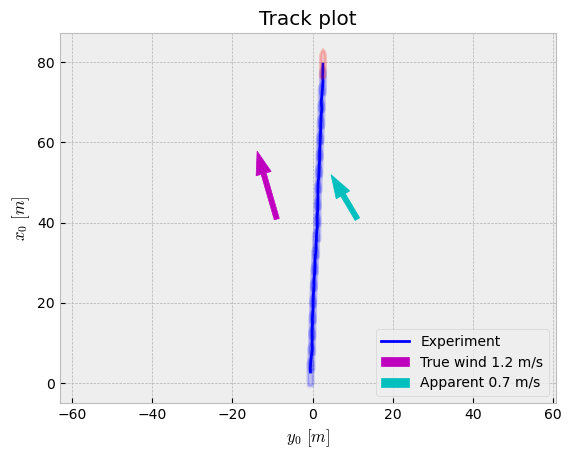

In [12]:
data_ = data.loc[0:140].copy()

dataframes = {
    'Experiment':data_,
}

time_window=[0,np.inf]

ax = track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], 
                 time_window=time_window, N=20);

In [13]:
calculate_fx(data=data_, rev=5).head()

,X_H,Y_H,N_H,thrust,X_P,V_x,C_L,X_R,Y_R,N_R,cog,aws,awa,X_W,Y_W,N_W,X_D,Y_D,N_D,fx
global time,,,,,,,,,,,,,,,,,,,,
0.000000,-6.613197,-1.671806,-9.860529,15.232086,13.449932,0.837083,-0.022125,-0.052273,-0.618542,2.057572,0.0566,1.72600,2.86530,2.056295,-3.344339,5.169394,8.840758,-5.634688,-2.633563,8.840758
0.199987,-6.825183,-2.430340,-12.551272,15.076178,13.312265,0.836350,-0.035856,-0.057541,-1.001607,3.331834,0.0732,1.75685,2.86415,2.130095,-3.479958,5.376956,8.559636,-6.911905,-3.842482,8.559636
0.400023,-6.827218,-3.215424,-11.207028,15.013069,13.256540,0.836068,-0.048720,-0.064933,-1.364285,4.538276,0.0877,1.77485,2.88945,2.177165,-3.212341,4.998740,8.541552,-7.792050,-1.670011,8.541552
0.599958,-6.894167,-3.442087,-11.313349,14.949534,13.200439,0.835788,-0.050720,-0.066257,-1.420188,4.724237,0.0901,1.77485,2.90255,2.174537,-3.034584,4.733270,8.414551,-7.896860,-1.855842,8.414551
0.800069,-6.657624,-2.721099,-12.358611,15.214100,13.434051,0.837001,-0.040644,-0.060121,-1.138248,3.786367,0.0803,1.73190,2.89620,2.072139,-2.971705,4.630494,8.788444,-6.831052,-3.941751,8.788444


In [14]:
df_force = model_wind.forces_from_motions(data=data_)
predict_fx_rev([5], data=data_, df_force=df_force).head()

global time
0.000000    35.782083
0.199987     9.455512
0.400023     9.783140
0.599958   -83.934980
0.800069    -9.283755
Name: fx, dtype: float64

In [15]:
result = fit_rev(data = data_)
result.x

array([4.07464528])

In [16]:
data_ = data.loc[0:1500].rolling(window=100).mean().dropna()
beta_ = smallest_signed_angle(data_['beta'])
R_crit=20
mask = ((beta_.abs() < np.deg2rad(1)) & 
        (data_['r'].abs() < data_['u'].mean() / (R_crit*ship_data['L'])) &
        (data_['tws'].abs() < 2)
        
        )
df_straight = data_.loc[mask].copy()

In [17]:
groups = df_straight.groupby(by='thrusterTarget')
df_straight = groups.filter(lambda x : len(x) > 50)
df_straight['thrusterTarget'].unique()

array([20., 40., 60.])

In [18]:
groups = df_straight.groupby(by='thrusterTarget')

In [19]:
groups['thrusterTarget'].count()

thrusterTarget
20.0    233
40.0     63
60.0    373
Name: thrusterTarget, dtype: int64

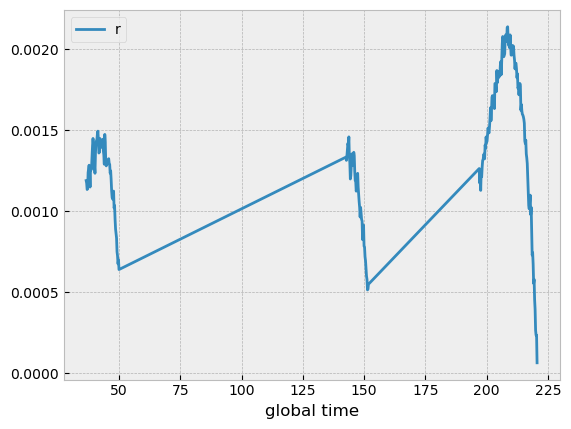

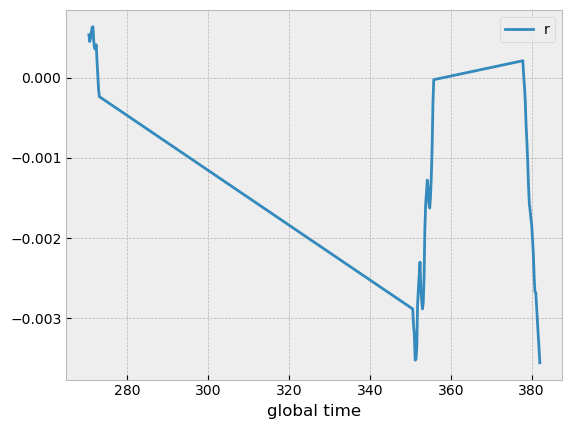

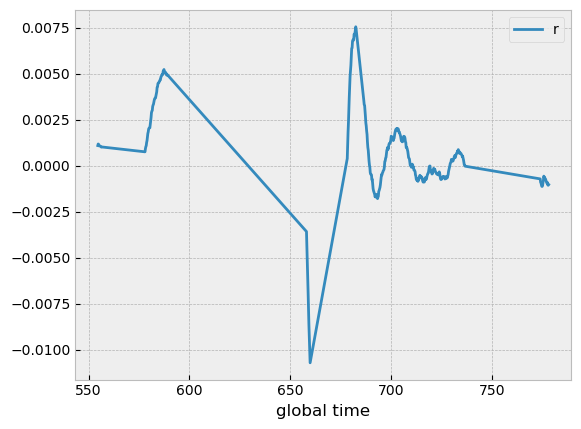

In [20]:
for thrusterTarget, group in groups:
    
    group.plot(y='r')

In [21]:
groups = df_straight.groupby(by='thrusterTarget')
Pd_to_rev = groups.apply(func=lambda x: fit_rev(x).x[0])
Pd_to_rev

thrusterTarget
20.0     4.112684
40.0     7.248295
60.0    12.561567
dtype: float64

In [22]:
X = pd.DataFrame(index=Pd_to_rev.index)
X['thrusterTarget'] = Pd_to_rev.index
X['const'] = 1
y = Pd_to_rev
Pd_model = sm.OLS(y,X)
Pd_model_fit = Pd_model.fit()

In [23]:
Pd_model_fit.summary()

[07/06/23 13:43:21] WARNING  /home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/statsmodels/ ]8;id=785851;file:///home/maa/anaconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=296206;file:///home/maa/anaconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             stats/stattools.py:74: ValueWarning: omni_normtest is not valid with                  
                             less than 8 observations; 3 samples were given.                                       
                               warn("omni_normtest is not valid with less than 8 observations; %i "                
                                                                                                                   

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     45.16
Date:                Thu, 06 Jul 2023   Prob (F-statistic):             0.0940
Time:                        13:43:21   Log-Likelihood:                -2.2560
No. Observations:                   3   AIC:                             8.512
Df Residuals:                       1   BIC:                             6.709
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
thrusterTarget     0.2112      0.031      6.720      0.094      -0.188       0.611
const             -0.4747      1.358     -0.350      0.786     -17.730      16.780
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   3.000
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.531
Skew:                          -0.707   Prob(JB):                        0.767
Kurtosis:                       1.500   Cond. No.                         114.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Axes: xlabel='thrusterTarget'>

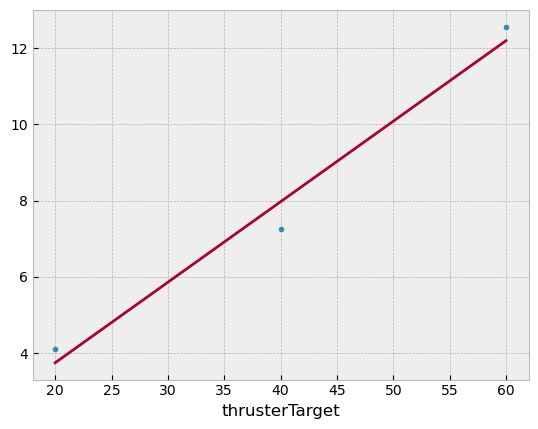

In [24]:
fig,ax=plt.subplots()
Pd_to_rev.plot(style='.', ax=ax)
Pd_model_fit.predict(X).plot(ax=ax)

<Axes: xlabel='global time'>

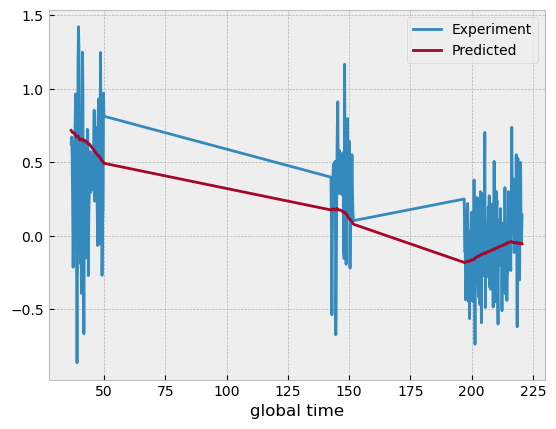

In [25]:
data_ = groups.get_group(20).copy()
df_force = model_wind.forces_from_motions(data=data_)

fig,ax=plt.subplots()
df_force.plot(y='fx', label='Experiment', ax=ax)
calculate_fx(data=data_, rev=Pd_to_rev.loc[20]).plot(y='fx', label='Predicted', ax=ax)

In [26]:
result = fit_rev(data = groups.get_group(60))
result.x

array([12.56156743])

<Axes: xlabel='global time'>

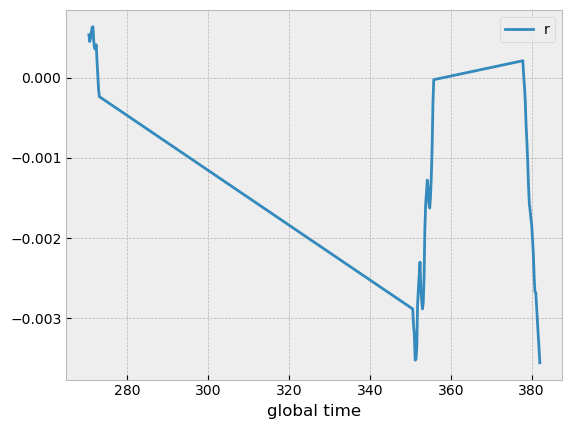

In [27]:
groups.get_group(40).plot(y='r')

<Axes: xlabel='global time'>

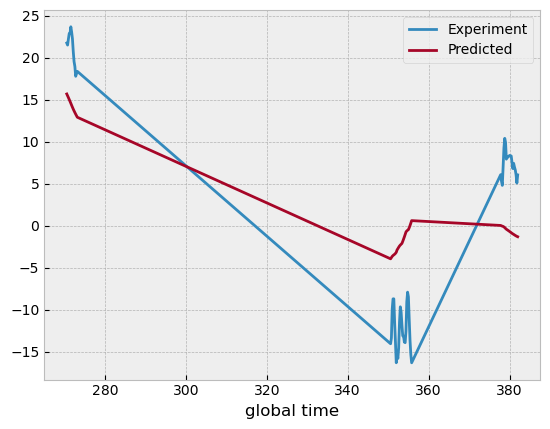

In [28]:
data_ = groups.get_group(40).copy()
df_force = model_wind.forces_from_motions(data=data_)

fig,ax=plt.subplots()
df_force.plot(y='fx', label='Experiment', ax=ax)
calculate_fx(data=data_, rev=Pd_to_rev.loc[40]).plot(y='fx', label='Predicted', ax=ax)

<Axes: xlabel='global time'>

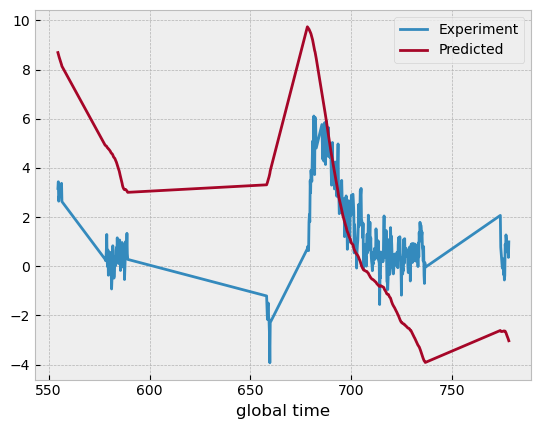

In [29]:
data_ = groups.get_group(60).copy()
df_force = model_wind.forces_from_motions(data=data_)

fig,ax=plt.subplots()
df_force.plot(y='fx', label='Experiment', ax=ax)
calculate_fx(data=data_, rev=Pd_to_rev.loc[60]).plot(y='fx', label='Predicted', ax=ax)

## Force

If the interia is further assumed to be correct, a force prediction error $\epsilon_F$ can instead be considered,
$$\epsilon_F = F - \hat{F}$$
This gives a more direct assessment of the force prediction model. One must however bare in mind that the assumed intertia also has some uncertainty that has now been excluded from the assessment. 

In [30]:
data = data_all.drop(columns=['mission','date'])
mask = data['thrusterTarget'].between(1,100)
data = data.loc[mask].copy()

groups = data.groupby(by='thrusterTarget')
data = groups.filter(lambda x : len(x) > 100)

X = data[['thrusterTarget']].copy()
X['const']=1
#data['rev'] = Pd_model_fit.predict(X)
data['rev'] = 8
states = data[['x0','y0','psi','u','v','r']]
control=data[model_wind.control_keys]

In [31]:
df_force_predicted = pd.DataFrame(model_wind.calculate_forces(states_dict=states, control=control))

In [32]:
df_force = model_wind.forces_from_motions(data=data)

In [33]:
df_force_predicted['fx'] = run(model_wind.lambda_X_D, inputs=df_force_predicted)
df_force_predicted['fy'] = run(model_wind.lambda_Y_D, inputs=df_force_predicted)
df_force_predicted['mz'] = run(model_wind.lambda_N_D, inputs=df_force_predicted)

<Axes: xlabel='global time'>

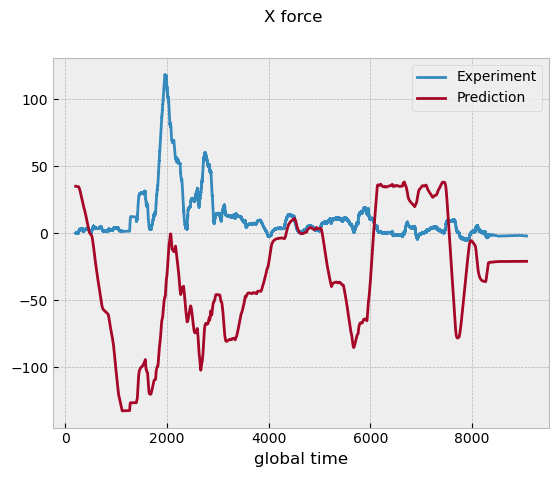

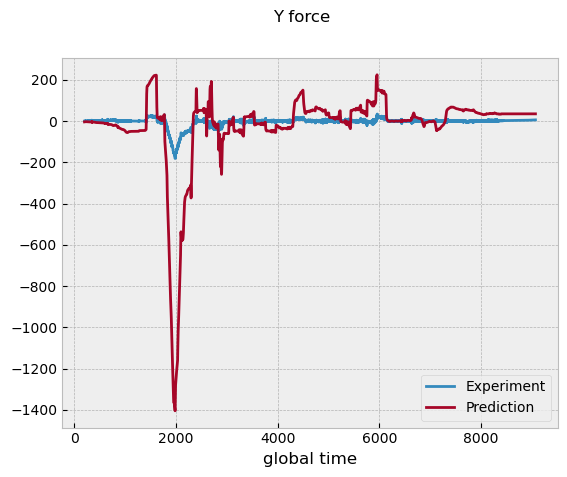

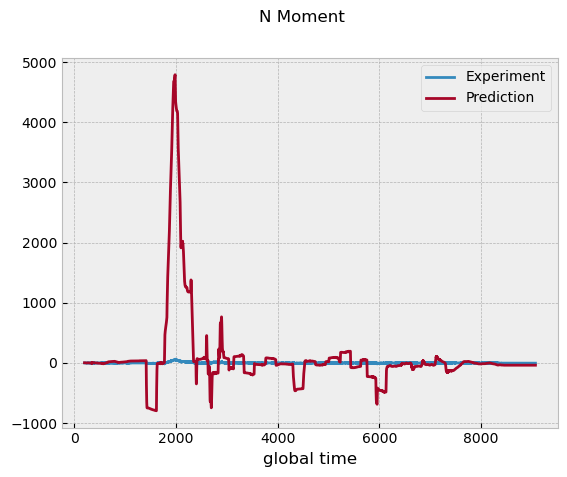

In [34]:
fig,ax=plt.subplots()
fig.suptitle('X force')
window=1000
df_force.rolling(window=window).mean().plot(y='fx', label='Experiment', ax=ax)
df_force_predicted.rolling(window=window).mean().plot(y='fx', label='Prediction', ax=ax)

fig,ax=plt.subplots()
fig.suptitle('Y force')

df_force.rolling(window=window).mean().plot(y='fy', label='Experiment', ax=ax)
df_force_predicted.rolling(window=window).mean().plot(y='fy', label='Prediction', ax=ax)

fig,ax=plt.subplots()
fig.suptitle('N Moment')

df_force.rolling(window=window).mean().plot(y='mz', label='Experiment', ax=ax)
df_force_predicted.rolling(window=window).mean().plot(y='mz', label='Prediction', ax=ax)

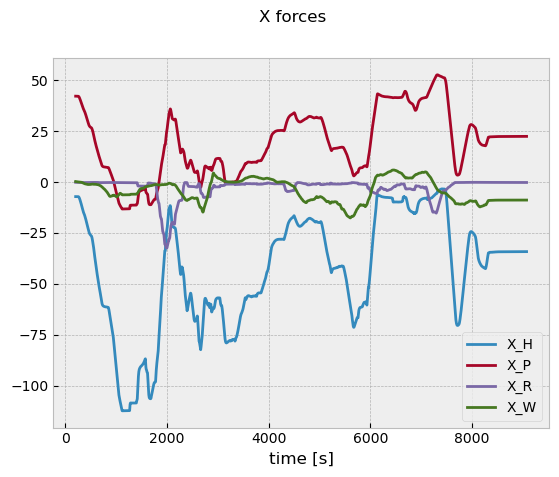

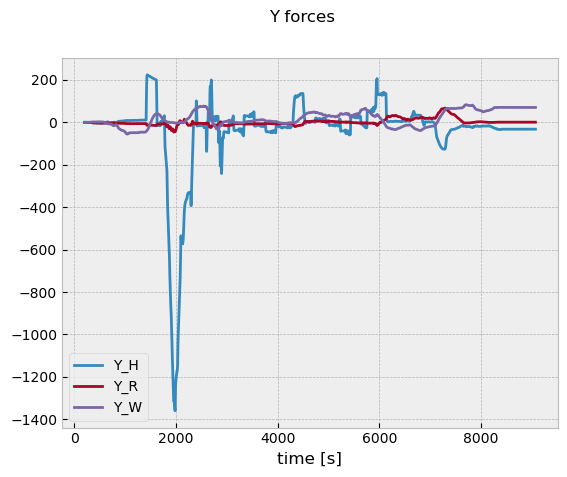

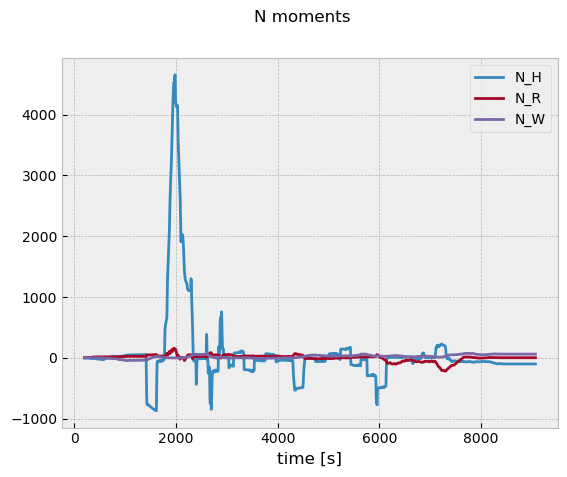

In [35]:
keys = list(get_function_subs(model_wind.X_D_eq).values())
fig,ax=plt.subplots()
fig.suptitle('X forces')

for key in keys:
    
    df_force_predicted.rolling(window=window).mean().plot(y=key, ax=ax)
    ax.set_xlabel('time [s]')
    
keys = list(get_function_subs(model_wind.Y_D_eq).values())
fig,ax=plt.subplots()
fig.suptitle('Y forces')

for key in keys:

    df_force_predicted.rolling(window=window).mean().plot(y=key, ax=ax)
    ax.set_xlabel('time [s]')
    
keys = list(get_function_subs(model_wind.N_D_eq).values())
fig,ax=plt.subplots()
fig.suptitle('N moments')

for key in keys:

    df_force_predicted.rolling(window=window).mean().plot(y=key, ax=ax)
    ax.set_xlabel('time [s]')



In [36]:
r2_score(y_true=df_force['fx'], y_pred=df_force_predicted['fx'])

-0.24343273653690023

In [37]:
r2_score(y_true=df_force['fy'], y_pred=df_force_predicted['fy'])

-0.30034560878543526

In [38]:
r2_score(y_true=df_force['mz'], y_pred=df_force_predicted['mz'])

-13.132068728149342